### BASIC HOG FEATURE EXTRACTION

[WARNING] Could not find image for 7006.jpg (Referenced in 4632.xml)
[WARNING] Could not find image for 5843.jpg (Referenced in 856.xml)
[WARNING] Could not find image for 12559.jpg (Referenced in 4555.xml)


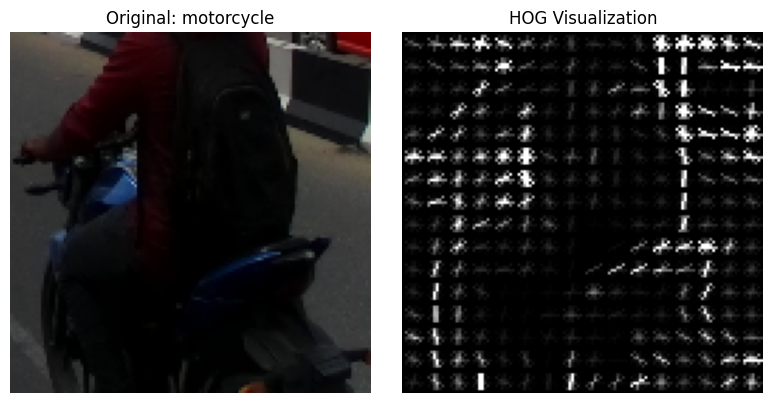

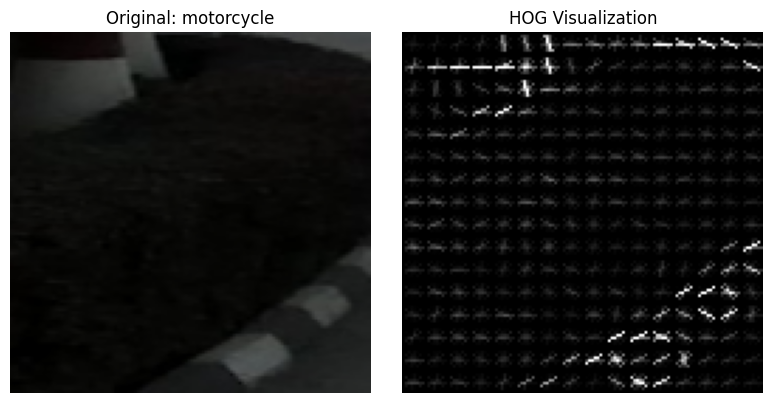

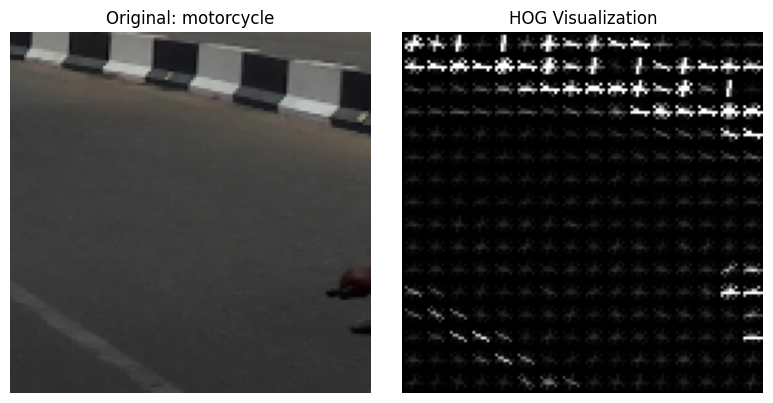

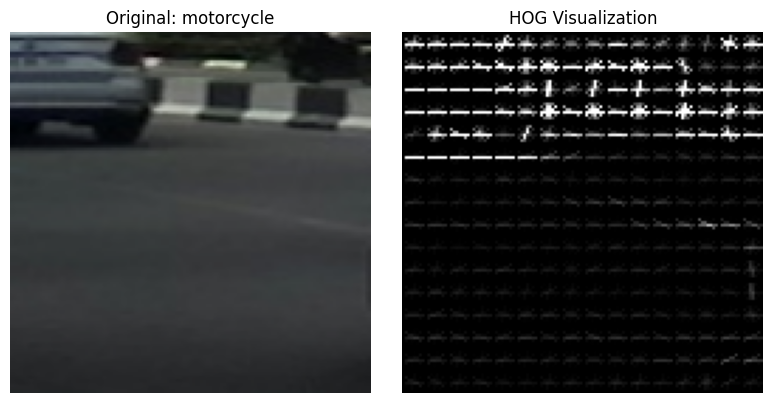

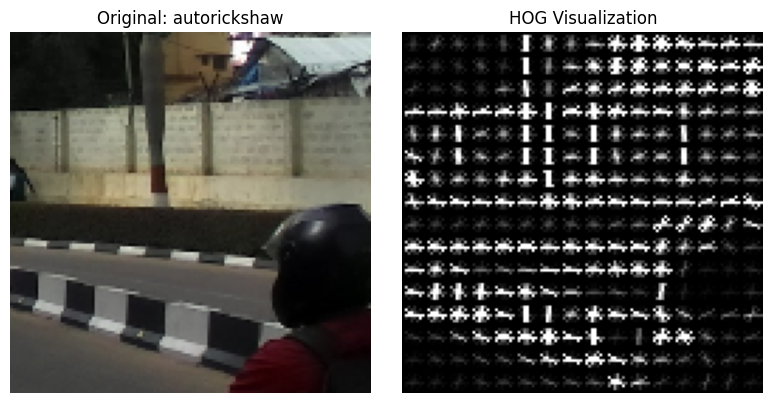

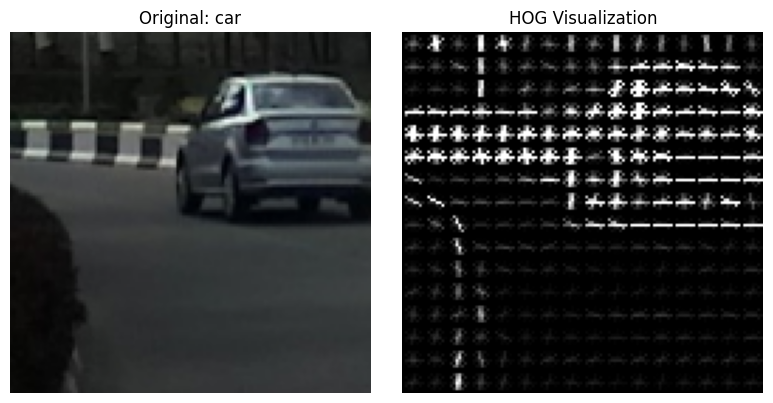

In [9]:
import os
import random
import xml.etree.ElementTree as ET
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

# Base directories
image_dir = Path(r"C:\Users\Sejal Hanmante\OneDrive\Desktop\idd detection\IDD_FGVD\train\images")
annotation_dir = Path(r"C:\Users\Sejal Hanmante\OneDrive\Desktop\idd detection\IDD_FGVD\train\annos")

# Get all XML files
xml_files = list(annotation_dir.glob("*.xml"))

# Shuffle for random selection (or loop all if needed)
random.shuffle(xml_files)

for xml_path in xml_files:
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Extract image filename from XML
        image_filename = root.find("filename").text
        image_basename = os.path.basename(image_filename)

        # Recursively search for image
        found_images = list(image_dir.rglob(image_basename))

        if not found_images:
            print(f"[WARNING] Could not find image for {image_basename} (Referenced in {xml_path.name})")
            continue

        image_path = found_images[0]

        # Read and convert image
        image = cv2.imread(str(image_path))
        if image is None:
            print(f"[WARNING] Image unreadable: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Iterate over objects in the annotation
        for obj in root.findall("object"):
            label = obj.find("name").text
            bndbox = obj.find("bndbox")

            xmin = int(float(bndbox.find("xmin").text))
            ymin = int(float(bndbox.find("ymin").text))
            xmax = int(float(bndbox.find("xmax").text))
            ymax = int(float(bndbox.find("ymax").text))

            # Crop and resize ROI
            roi = image[ymin:ymax, xmin:xmax]
            if roi.size == 0:
                print(f"[WARNING] Empty crop for {image_path.name}, skipping.")
                continue

            roi_resized = cv2.resize(roi, (128, 128))
            gray = cv2.cvtColor(roi_resized, cv2.COLOR_RGB2GRAY)

            # HOG feature extraction
            features, hog_image = hog(
                gray, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys'
            )
            hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))

            # Plot original and HOG
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(roi_resized)
            plt.title(f"Original: {label}")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(hog_image, cmap='gray')
            plt.title("HOG Visualization")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        break  # Remove this if you want to loop over all files

    except Exception as e:
        print(f"[ERROR] Processing {xml_path.name} failed: {e}")


### HOG Object detection


Visualization 1 for 3299.xml


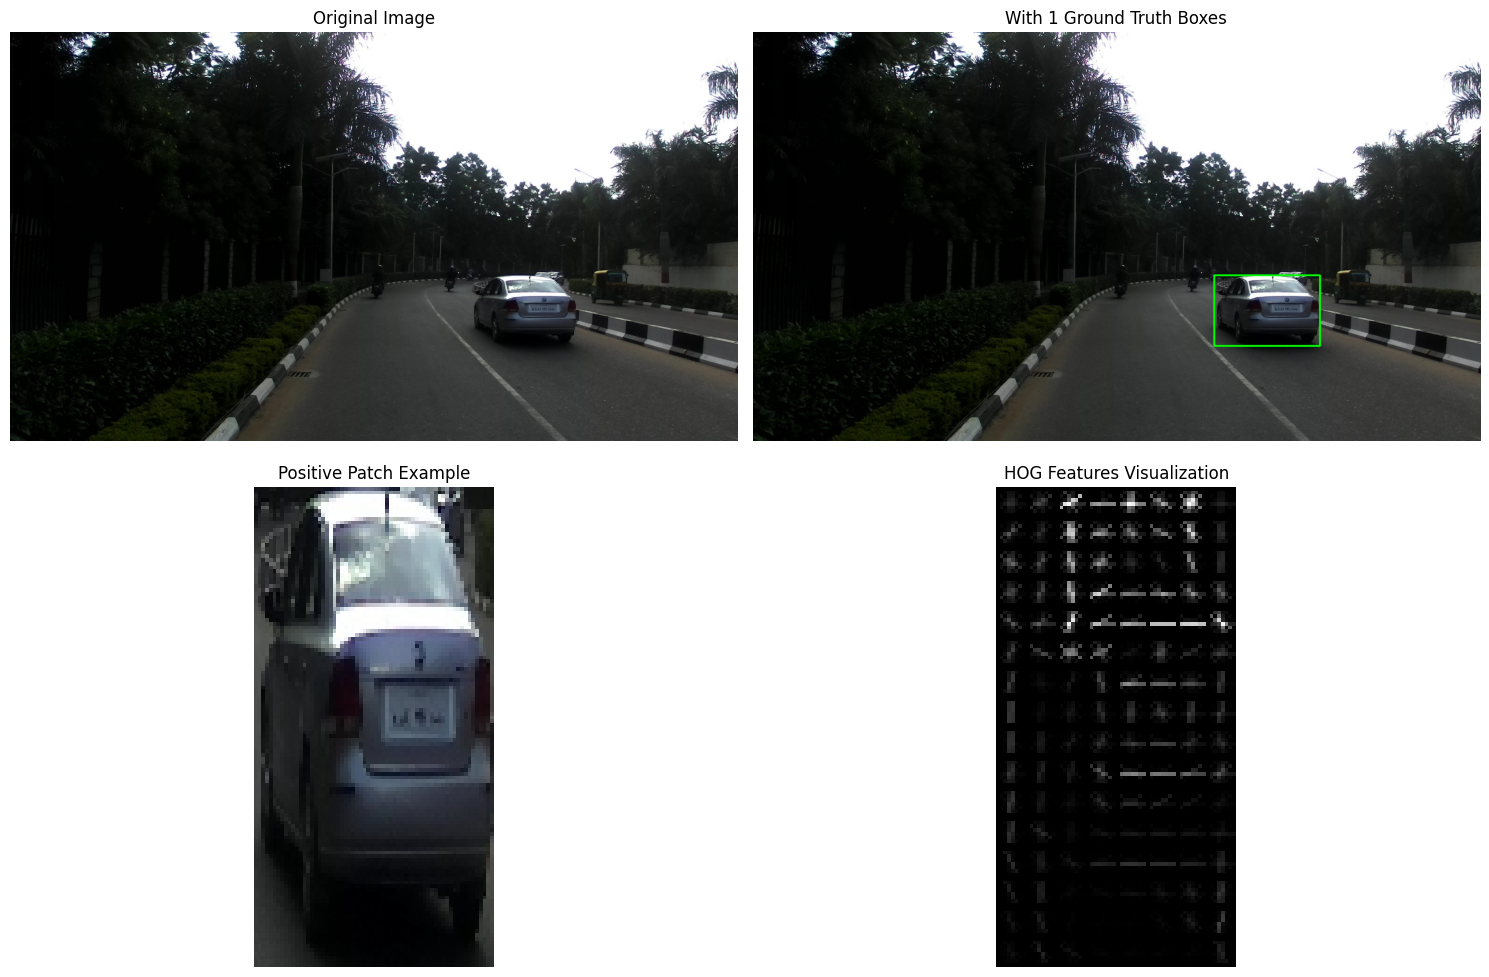

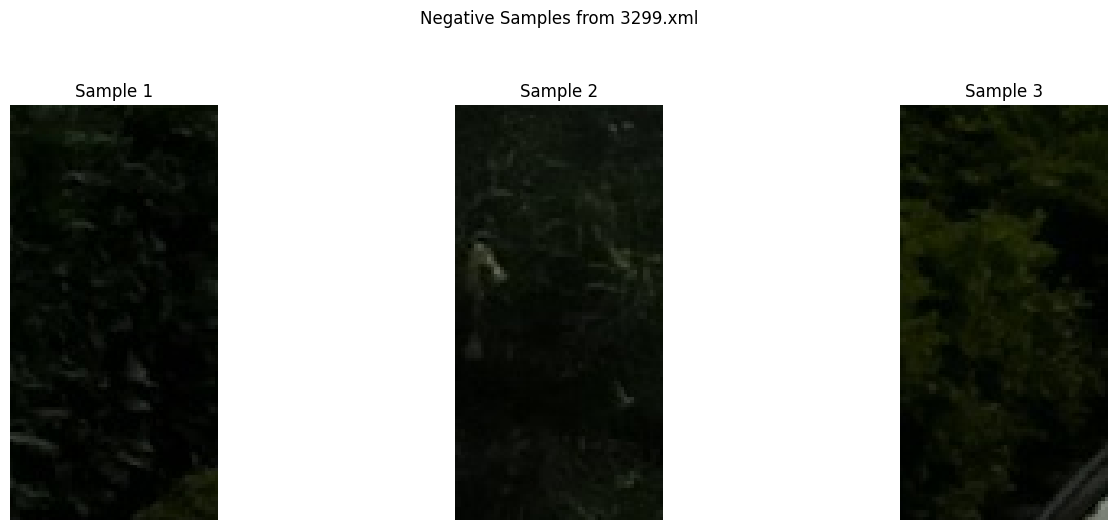


Visualization 2 for 995.xml


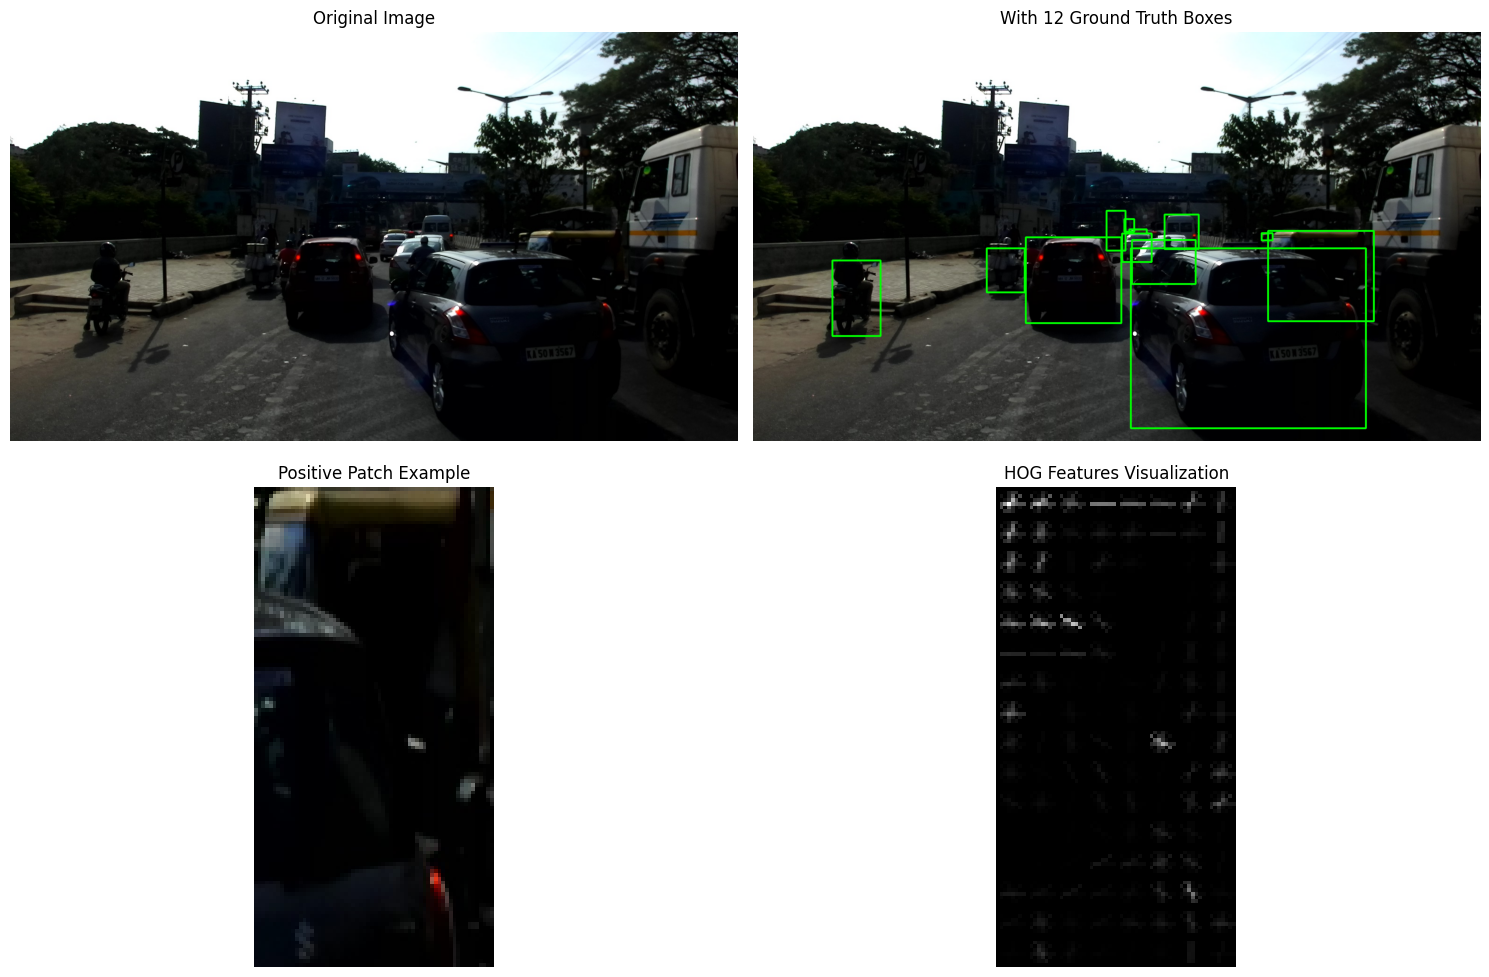

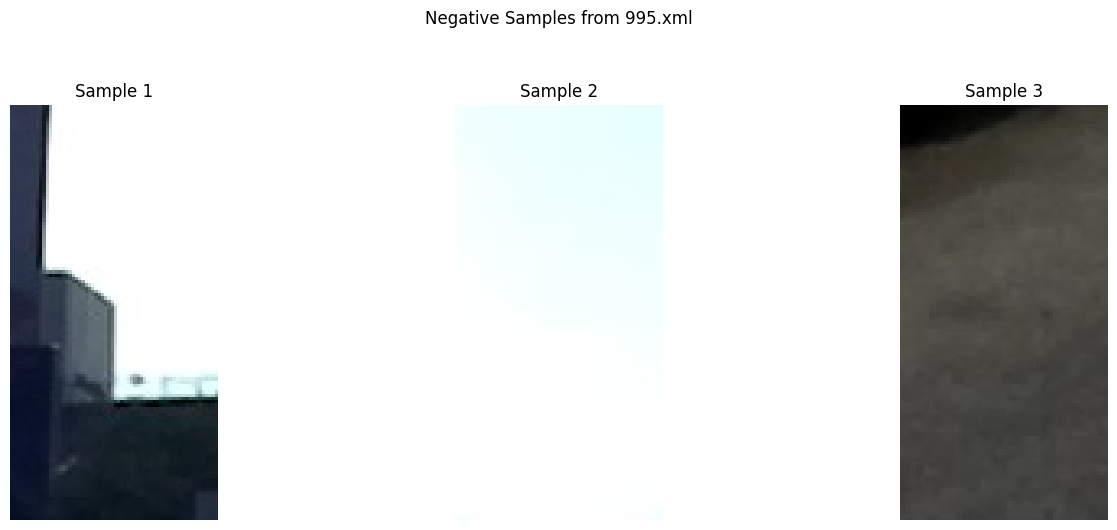


Visualization 3 for 699.xml


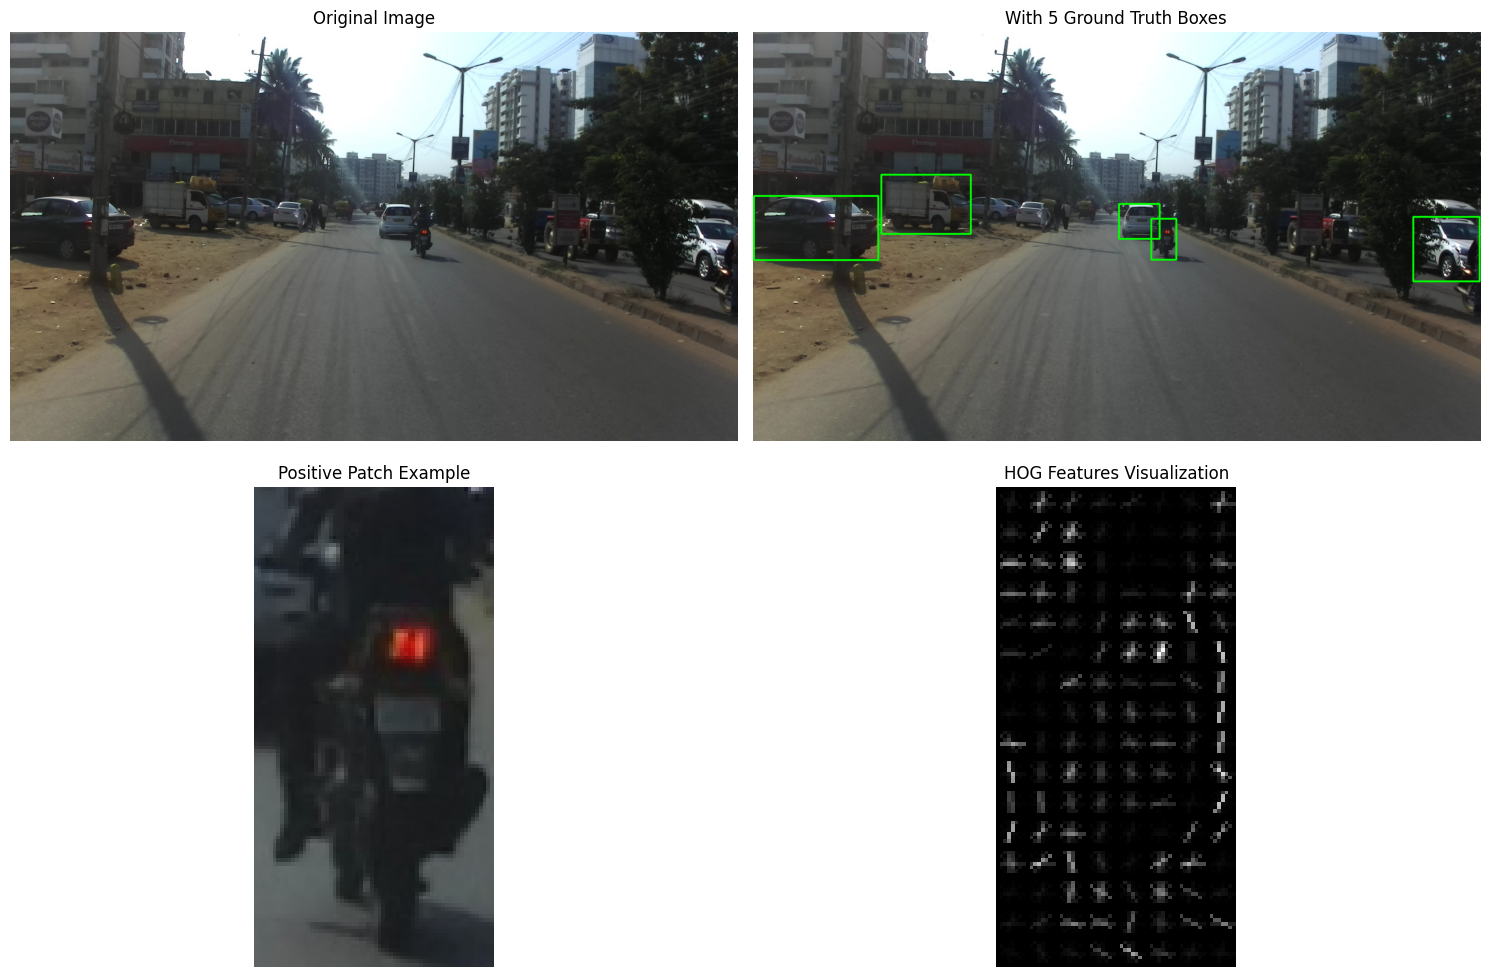

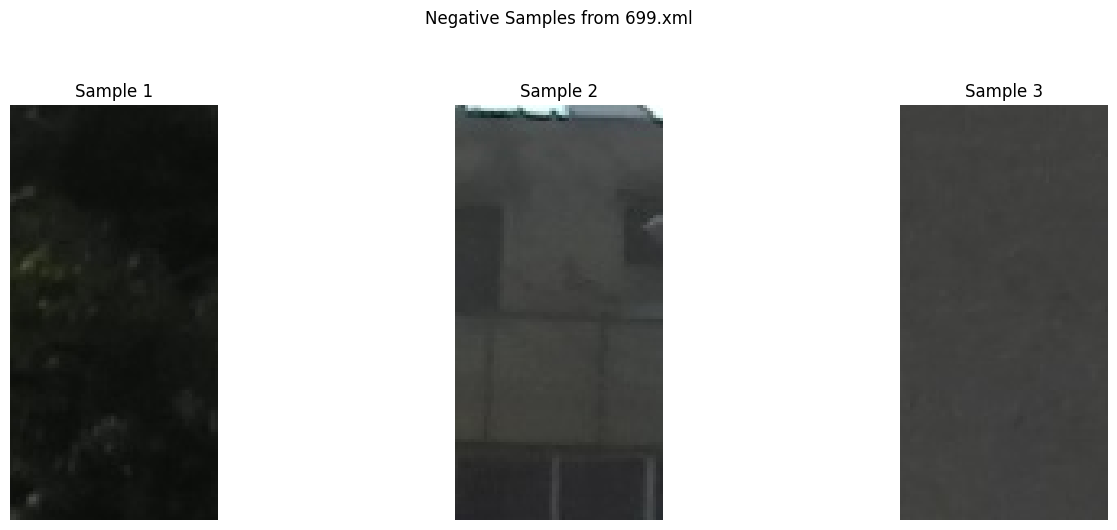

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path
from xml.etree import ElementTree as ET
from skimage.feature import hog

# --- Configuration ---
image_dir = Path(r"D:\NLPInsuranceProject\AutonomousDrivingGanMV\idd detection\IDD_FGVD\train\images")  # Replace with your actual path
xml_dir = Path(r"D:\NLPInsuranceProject\AutonomousDrivingGanMV\idd detection\IDD_FGVD\train\annos")  # Replace with your actual path
win_size = (64, 128)  # Standard HOG window size
hog_params = {
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'orientations': 9,
    'block_norm': 'L2-Hys'
}

# --- Helper Functions ---
def safe_parse_coordinate(text):
    """Safely parse coordinate value, converting float to int if needed."""
    try:
        value = float(text)
        return int(round(value))
    except (ValueError, TypeError, AttributeError):
        return None

def parse_voc(xml_path):
    """Parse VOC format XML file and return list of bounding boxes."""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        bboxes = []
        
        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            if bbox is None:
                continue
                
            xmin = safe_parse_coordinate(bbox.find("xmin").text if bbox.find("xmin") is not None else None)
            ymin = safe_parse_coordinate(bbox.find("ymin").text if bbox.find("ymin") is not None else None)
            xmax = safe_parse_coordinate(bbox.find("xmax").text if bbox.find("xmax") is not None else None)
            ymax = safe_parse_coordinate(bbox.find("ymax").text if bbox.find("ymax") is not None else None)

            if None in (xmin, ymin, xmax, ymax):
                print(f"[Warning] Skipping malformed box in: {xml_path}")
                continue

            if xmax <= xmin or ymax <= ymin:
                print(f"[Warning] Skipping invalid box dimensions in: {xml_path}")
                continue

            bboxes.append((xmin, ymin, xmax, ymax))
            
        return bboxes
    except ET.ParseError as e:
        print(f"[Error] Failed to parse {xml_path}: {str(e)}")
        return []

# --- Visualization Functions ---
def visualize_hog_features(xml_path):
    """Visualize HOG features for a sample image and its annotations."""
    img_path = image_dir / (xml_path.stem + ".jpg")
    if not img_path.exists():
        print(f"Image not found: {img_path}")
        return
    
    # Load and prepare image
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Failed to load image: {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get bounding boxes
    bboxes = parse_voc(xml_path)
    if not bboxes:
        print(f"No valid boxes found in {xml_path}")
        return
    
    # Create visualization figure
    plt.figure(figsize=(15, 10))
    
    # 1. Original Image
    plt.subplot(2, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    
    # 2. Image with Bounding Boxes
    img_boxes = img.copy()
    for (xmin, ymin, xmax, ymax) in bboxes:
        cv2.rectangle(img_boxes, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
    plt.subplot(2, 2, 2)
    plt.imshow(img_boxes)
    plt.title(f"With {len(bboxes)} Ground Truth Boxes")
    plt.axis('off')
    
    # 3. Positive Patch Example
    xmin, ymin, xmax, ymax = bboxes[0]  # Take first box
    patch = img[ymin:ymax, xmin:xmax]
    patch = cv2.resize(patch, win_size)
    plt.subplot(2, 2, 3)
    plt.imshow(patch)
    plt.title("Positive Patch Example")
    plt.axis('off')
    
    # 4. HOG Features Visualization
    gray_patch = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
    _, hog_image = hog(gray_patch, visualize=True, **hog_params)
    plt.subplot(2, 2, 4)
    plt.imshow(hog_image, cmap='gray')
    plt.title("HOG Features Visualization")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_negative_samples(xml_path, num_samples=3):
    """Visualize negative samples (non-car patches) from an image."""
    img_path = image_dir / (xml_path.stem + ".jpg")
    if not img_path.exists():
        print(f"Image not found: {img_path}")
        return
    
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Failed to load image: {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    bboxes = parse_voc(xml_path)
    h, w = img.shape[:2]
    
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Negative Samples from {xml_path.name}", y=1.05)
    
    samples_collected = 0
    attempts = 0
    max_attempts = 100
    
    while samples_collected < num_samples and attempts < max_attempts:
        y1 = random.randint(0, h - win_size[1] - 1)
        x1 = random.randint(0, w - win_size[0] - 1)
        y2, x2 = y1 + win_size[1], x1 + win_size[0]
        
        # Check for overlap with any bounding box
        overlap = False
        for (bx1, by1, bx2, by2) in bboxes:
            if not (x2 < bx1 or x1 > bx2 or y2 < by1 or y1 > by2):
                overlap = True
                break
                
        if not overlap:
            patch = img[y1:y2, x1:x2]
            plt.subplot(1, num_samples, samples_collected + 1)
            plt.imshow(patch)
            plt.title(f"Sample {samples_collected + 1}")
            plt.axis('off')
            samples_collected += 1
            
        attempts += 1
    
    if samples_collected < num_samples:
        print(f"Only found {samples_collected} negative samples after {attempts} attempts")
    
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
def main():
    # Verify paths exist
    if not image_dir.exists() or not xml_dir.exists():
        print("Error: Image or XML directory not found")
        return
    
    # Get all XML files
    xml_files = list(xml_dir.glob("*.xml"))
    if not xml_files:
        print("No XML files found in the directory")
        return
    
    # Visualize for 3 random files
    for i, xml_path in enumerate(random.sample(xml_files, min(3, len(xml_files)))):
        print(f"\nVisualization {i+1} for {xml_path.name}")
        
        # Visualize HOG features
        visualize_hog_features(xml_path)
        
        # Visualize negative samples
        visualize_negative_samples(xml_path)

if __name__ == "__main__":
    main()

In [5]:
import cv2
import numpy as np
import pandas as pd
import random
from pathlib import Path
from xml.etree import ElementTree as ET
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import logging

# --- Configuration ---
image_dir = Path(r"D:\NLPInsuranceProject\AutonomousDrivingGanMV\idd detection\IDD_FGVD\train\images")
xml_dir = Path(r"D:\NLPInsuranceProject\AutonomousDrivingGanMV\idd detection\IDD_FGVD\train\annos")
output_csv = Path("hog_svm_metrics.csv")
win_size = (64, 128)  # Standard HOG window size
hog_params = {
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'orientations': 9,
    'block_norm': 'L2-Hys'
}
neg_samples_per_image = 2  # Number of negative samples per positive image
test_size = 0.2  # Test set size
random_state = 42  # Random seed for reproducibility

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# --- Helper Functions with Error Handling ---
def safe_parse_coordinate(text):
    """Safely parse coordinate value with error handling."""
    try:
        return int(round(float(text)))
    except (ValueError, TypeError, AttributeError):
        return None

def parse_voc(xml_path):
    """Parse VOC XML file with robust error handling."""
    bboxes = []
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
    except ET.ParseError as e:
        logger.warning(f"XML parsing error in {xml_path.name}: {str(e)}")
        return bboxes
    except Exception as e:
        logger.warning(f"Unexpected error parsing {xml_path.name}: {str(e)}")
        return bboxes

    for obj in root.findall('object'):
        try:
            bb = obj.find('bndbox')
            if bb is None:
                continue
                
            coords = [
                safe_parse_coordinate(bb.find('xmin').text if bb.find('xmin') is not None else None),
                safe_parse_coordinate(bb.find('ymin').text if bb.find('ymin') is not None else None),
                safe_parse_coordinate(bb.find('xmax').text if bb.find('xmax') is not None else None),
                safe_parse_coordinate(bb.find('ymax').text if bb.find('ymax') is not None else None)
            ]
            
            if None in coords:
                logger.debug(f"Skipping box with None coordinates in {xml_path.name}")
                continue
                
            x1, y1, x2, y2 = coords
            if x2 <= x1 or y2 <= y1:
                logger.debug(f"Skipping invalid box dimensions in {xml_path.name}: {(x1, y1, x2, y2)}")
                continue
                
            bboxes.append((x1, y1, x2, y2))
        except Exception as e:
            logger.warning(f"Error processing object in {xml_path.name}: {str(e)}")
            continue
            
    return bboxes

def extract_hog_features(img, win_size, hog_params):
    """Extract HOG features with error handling."""
    try:
        if img is None:
            raise ValueError("Empty image provided")
            
        if img.size == 0:
            raise ValueError("Zero-sized image")
            
        # Convert to grayscale if needed
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img
            
        # Check image size matches window size
        if gray.shape[0] != win_size[1] or gray.shape[1] != win_size[0]:
            gray = cv2.resize(gray, win_size)
            
        features = hog(gray, visualize=False, **hog_params)
        return features
    except Exception as e:
        logger.error(f"Error extracting HOG features: {str(e)}")
        return None

def build_dataset():
    """Build dataset with progress tracking and error handling."""
    X, y = [], []
    xml_files = list(xml_dir.glob('*.xml'))
    
    if not xml_files:
        logger.error("No XML files found in the directory")
        return None, None
        
    logger.info(f"Found {len(xml_files)} XML files. Processing...")
    
    for xml_path in tqdm(xml_files, desc="Processing images"):
        try:
            # Load corresponding image
            img_path = image_dir / f"{xml_path.stem}.jpg"
            if not img_path.exists():
                logger.debug(f"Image not found: {img_path.name}")
                continue
                
            img = cv2.imread(str(img_path))
            if img is None:
                logger.debug(f"Failed to load image: {img_path.name}")
                continue
                
            h, w = img.shape[:2]
            bboxes = parse_voc(xml_path)
            
            # Process positive samples (bounding boxes)
            for (x1, y1, x2, y2) in bboxes:
                try:
                    # Ensure coordinates are within image bounds
                    x1, y1 = max(0, x1), max(0, y1)
                    x2, y2 = min(w, x2), min(h, y2)
                    
                    if x2 <= x1 or y2 <= y1:
                        continue
                        
                    patch = img[y1:y2, x1:x2]
                    features = extract_hog_features(patch, win_size, hog_params)
                    if features is not None:
                        X.append(features)
                        y.append(1)
                except Exception as e:
                    logger.warning(f"Error processing positive sample in {xml_path.name}: {str(e)}")
                    continue
                    
            # Process negative samples (random non-object patches)
            attempts = 0
            negs_collected = 0
            while negs_collected < neg_samples_per_image and attempts < 50:
                try:
                    x1 = random.randint(0, w - win_size[0])
                    y1 = random.randint(0, h - win_size[1])
                    x2, y2 = x1 + win_size[0], y1 + win_size[1]
                    
                    # Check for overlap with any bounding box
                    overlap = False
                    for (bx1, by1, bx2, by2) in bboxes:
                        if not (x2 < bx1 or x1 > bx2 or y2 < by1 or y1 > by2):
                            overlap = True
                            break
                            
                    if not overlap:
                        patch = img[y1:y2, x1:x2]
                        features = extract_hog_features(patch, win_size, hog_params)
                        if features is not None:
                            X.append(features)
                            y.append(0)
                            negs_collected += 1
                except Exception as e:
                    logger.warning(f"Error generating negative sample in {xml_path.name}: {str(e)}")
                finally:
                    attempts += 1
                    
        except Exception as e:
            logger.error(f"Error processing {xml_path.name}: {str(e)}")
            continue
            
    if not X:
        logger.error("No valid samples were collected")
        return None, None
        
    logger.info(f"Dataset built with {len(X)} samples ({sum(y)} positive, {len(y)-sum(y)} negative)")
    return np.array(X), np.array(y)

def train_and_evaluate(X, y):
    """Train SVM classifier and evaluate performance."""
    try:
        # Split dataset
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, 
            test_size=test_size, 
            stratify=y, 
            random_state=random_state
        )
        
        logger.info(f"Train set: {X_train.shape[0]} samples, Test set: {X_test.shape[0]} samples")
        
        # Train classifier
        clf = LinearSVC(max_iter=10000, random_state=random_state)
        logger.info("Training SVM classifier...")
        clf.fit(X_train, y_train)
        
        # Evaluate
        y_pred = clf.predict(X_test)
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'num_train_samples': X_train.shape[0],
            'num_test_samples': X_test.shape[0],
            'positive_ratio': sum(y) / len(y)
        }
        
        return metrics, clf
    except Exception as e:
        logger.error(f"Error in training/evaluation: {str(e)}")
        return None, None

def save_metrics(metrics, output_path):
    """Save metrics to CSV file."""
    try:
        df = pd.DataFrame([metrics])
        df.to_csv(output_path, index=False)
        logger.info(f"Metrics saved to {output_path}")
        return True
    except Exception as e:
        logger.error(f"Failed to save metrics: {str(e)}")
        return False

def main():
    """Main execution pipeline."""
    # Verify directories exist
    if not image_dir.exists():
        logger.error(f"Image directory not found: {image_dir}")
        return
    if not xml_dir.exists():
        logger.error(f"XML directory not found: {xml_dir}")
        return
        
    # Build dataset
    X, y = build_dataset()
    if X is None:
        return
        
    # Train and evaluate
    metrics, clf = train_and_evaluate(X, y)
    if metrics is None:
        return
        
    # Print and save results
    logger.info("\nEvaluation Metrics:")
    for k, v in metrics.items():
        if isinstance(v, float):
            logger.info(f"{k:>20}: {v:.4f}")
        else:
            logger.info(f"{k:>20}: {v}")
            
    save_metrics(metrics, output_csv)

if __name__ == '__main__':
    main()

2025-04-22 20:30:45,706 - INFO - Found 3535 XML files. Processing...
Processing images: 100%|██████████| 3535/3535 [02:45<00:00, 21.39it/s]
2025-04-22 20:33:31,000 - INFO - Dataset built with 22769 samples (15701 positive, 7068 negative)
2025-04-22 20:33:31,860 - INFO - Train set: 18215 samples, Test set: 4554 samples
2025-04-22 20:33:31,860 - INFO - Training SVM classifier...
C:\Users\Sejal Hanmante\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
2025-04-22 20:35:48,183 - INFO - 
Evaluation Metrics:
2025-04-22 20:35:48,185 - INFO -             accuracy: 0.9078
2025-04-22 20:35:48,186 - INFO -            precision: 0.9421
2025-04-22 20:35:48,187 - INFO -               recall: 0.9229
2025-04-22 20:35:48,188 - INFO -             f1_score: 0.9324
2025-04-22 20:35:48,190 - INFO -    num_train_samples: 1

2025-04-22 23:55:49,599 - INFO - Found 3535 XML files. Processing...
Processing images: 100%|██████████| 3535/3535 [01:28<00:00, 39.88it/s]
2025-04-22 23:57:18,252 - INFO - 
Class distribution:
2025-04-22 23:57:18,262 - INFO -             car: 5113
2025-04-22 23:57:18,262 - INFO -           truck: 1010
2025-04-22 23:57:18,267 - INFO -      motorcycle: 3428
2025-04-22 23:57:18,269 - INFO -             bus: 797
2025-04-22 23:57:18,271 - INFO -        mini-bus: 200
2025-04-22 23:57:18,274 - INFO -    autorickshaw: 2413
2025-04-22 23:57:18,578 - INFO - 
Train set: 10368 samples
2025-04-22 23:57:18,578 - INFO - Test set: 2593 samples
2025-04-22 23:57:18,585 - INFO - Training classifier...
C:\Users\Sejal Hanmante\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[LibLinear]

2025-04-23 00:00:31,429 - INFO - 
Classification report saved to vehicle_classification_metrics.csv
2025-04-23 00:00:31,429 - INFO - 
Overall accuracy: 0.8207
2025-04-23 00:00:31,437 - INFO - 
Detailed classification report:
2025-04-23 00:00:31,536 - INFO - Processing scale 0.50 (32x64)


              precision    recall  f1-score      support
car            0.764471  0.792961  0.778455   483.000000
truck          0.662252  0.628931  0.645161   159.000000
motorcycle     0.866986  0.885630  0.876209  1023.000000
bus            0.512821  0.500000  0.506329    40.000000
mini-bus       0.895197  0.896501  0.895849   686.000000
autorickshaw   0.611765  0.514851  0.559140   202.000000
accuracy       0.820671  0.820671  0.820671     0.820671
macro avg      0.718915  0.703146  0.710190  2593.000000
weighted avg   0.817454  0.820671  0.818622  2593.000000


2025-04-23 00:00:40,456 - INFO - Processing scale 0.75 (48x96)
2025-04-23 00:00:48,788 - INFO - Processing scale 1.00 (64x128)
2025-04-23 00:00:56,530 - INFO - Processing scale 1.25 (80x160)
2025-04-23 00:01:04,147 - INFO - Processing scale 1.50 (96x192)


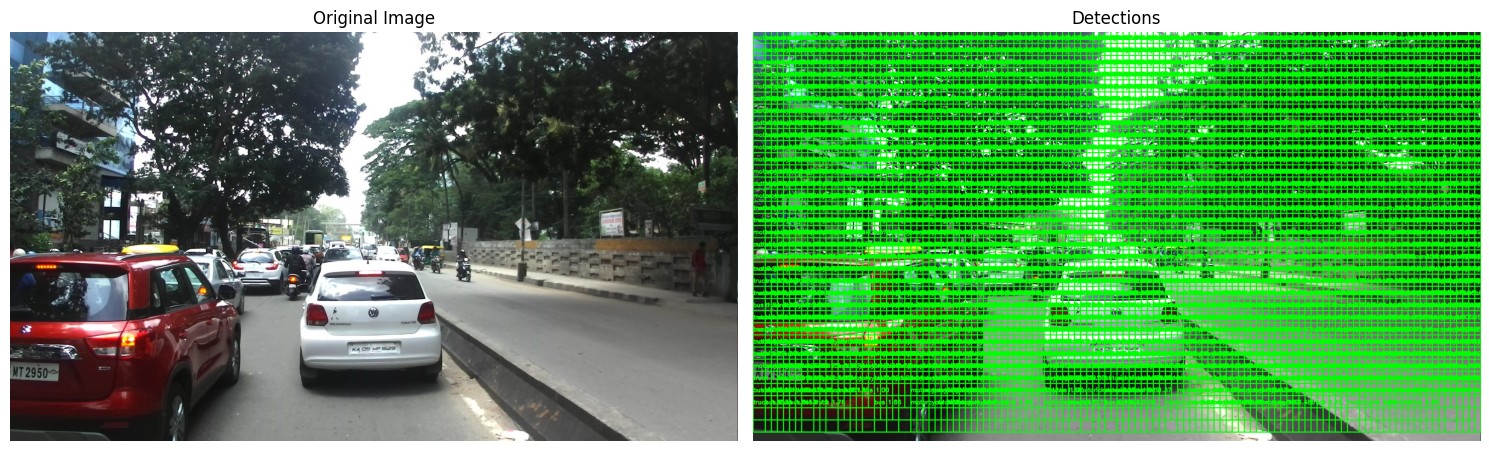

In [8]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from xml.etree import ElementTree as ET
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import logging

# --- Configuration ---
image_dir = Path(r"D:\NLPInsuranceProject\AutonomousDrivingGanMV\idd detection\IDD_FGVD\train\images")
xml_dir = Path(r"D:\NLPInsuranceProject\AutonomousDrivingGanMV\idd detection\IDD_FGVD\train\annos")
output_csv = Path("vehicle_classification_metrics.csv")
win_size = (64, 128)
hog_params = {
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'orientations': 9,
    'block_norm': 'L2-Hys'
}
neg_samples_per_image = 2
test_size = 0.2
random_state = 42

# Define your vehicle classes
CLASSES = ['car', 'truck', 'motorcycle', 'bus', 'mini-bus', 'autorickshaw']

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('vehicle_classification.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def safe_parse_coordinate(text):
    """Safely parse coordinate value with error handling."""
    try:
        return int(round(float(text)))
    except (ValueError, TypeError, AttributeError):
        return None

def parse_voc_with_classes(xml_path):
    """Parse VOC XML and return list of (bbox, class_name) tuples with robust error handling."""
    objects = []
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
    except ET.ParseError as e:
        logger.warning(f"XML parsing error in {xml_path.name}: {str(e)}")
        return objects
    except Exception as e:
        logger.warning(f"Unexpected error parsing {xml_path.name}: {str(e)}")
        return objects

    for obj in root.findall('object'):
        try:
            # Get class name
            name_elem = obj.find('name')
            class_name = name_elem.text.lower() if name_elem is not None else None
            if class_name not in CLASSES:
                logger.debug(f"Skipping object with unknown class: {class_name}")
                continue

            # Get bounding box
            bb = obj.find('bndbox')
            if bb is None:
                continue
                
            # Parse coordinates
            coords = [
                safe_parse_coordinate(bb.find('xmin').text if bb.find('xmin') is not None else None),
                safe_parse_coordinate(bb.find('ymin').text if bb.find('ymin') is not None else None),
                safe_parse_coordinate(bb.find('xmax').text if bb.find('xmax') is not None else None),
                safe_parse_coordinate(bb.find('ymax').text if bb.find('ymax') is not None else None)
            ]
            
            # Validate coordinates
            if None in coords:
                logger.debug(f"Skipping box with None coordinates in {xml_path.name}")
                continue
                
            x1, y1, x2, y2 = coords
            if x2 <= x1 or y2 <= y1:
                logger.debug(f"Skipping invalid box dimensions in {xml_path.name}: {(x1, y1, x2, y2)}")
                continue
                
            objects.append((x1, y1, x2, y2, class_name))
        except Exception as e:
            logger.warning(f"Error processing object in {xml_path.name}: {str(e)}")
            continue
            
    return objects

def extract_hog_features_safe(img_patch, win_size, hog_params):
    """
    Safely extract HOG features with proper image conversion and error handling.
    Handles both color and grayscale images.
    """
    try:
        # Convert to grayscale if needed
        if len(img_patch.shape) == 3:
            gray_patch = cv2.cvtColor(img_patch, cv2.COLOR_BGR2GRAY)
        else:
            gray_patch = img_patch
        
        # Resize to window size
        resized = cv2.resize(gray_patch, win_size)
        
        # Verify image dimensions
        if len(resized.shape) != 2:
            raise ValueError(f"Expected 2D image, got shape {resized.shape}")
        
        # Extract HOG features
        features = hog(
            resized,
            pixels_per_cell=hog_params['pixels_per_cell'],
            cells_per_block=hog_params['cells_per_block'],
            orientations=hog_params['orientations'],
            block_norm=hog_params['block_norm']
        )
        return features
    except Exception as e:
        logger.warning(f"Error extracting HOG features: {str(e)}")
        return None

def build_multiclass_dataset():
    """Build dataset with multi-class labels and proper error handling."""
    X, y = [], []
    xml_files = list(xml_dir.glob('*.xml'))
    label_encoder = LabelEncoder().fit(CLASSES)
    
    if not xml_files:
        logger.error("No XML files found in the directory")
        return None, None, None
        
    logger.info(f"Found {len(xml_files)} XML files. Processing...")
    
    for xml_path in tqdm(xml_files, desc="Processing images"):
        try:
            # Load corresponding image
            img_path = image_dir / f"{xml_path.stem}.jpg"
            if not img_path.exists():
                logger.debug(f"Image not found: {img_path.name}")
                continue
                
            img = cv2.imread(str(img_path))
            if img is None:
                logger.debug(f"Failed to load image: {img_path.name}")
                continue
                
            h, w = img.shape[:2]
            objects = parse_voc_with_classes(xml_path)
            
            # Process annotated objects (positive samples)
            for (x1, y1, x2, y2, class_name) in objects:
                try:
                    # Ensure coordinates are within image bounds
                    x1, y1 = max(0, x1), max(0, y1)
                    x2, y2 = min(w, x2), min(h, y2)
                    
                    if x2 <= x1 or y2 <= y1:
                        continue
                        
                    patch = img[y1:y2, x1:x2]
                    features = extract_hog_features_safe(patch, win_size, hog_params)
                    if features is not None:
                        X.append(features)
                        y.append(class_name)
                except Exception as e:
                    logger.warning(f"Error processing positive sample in {xml_path.name}: {str(e)}")
                    continue
                    
            # Process negative samples (background)
            attempts = 0
            negs_collected = 0
            while negs_collected < neg_samples_per_image and attempts < 50:
                try:
                    x1 = random.randint(0, w - win_size[0])
                    y1 = random.randint(0, h - win_size[1])
                    x2, y2 = x1 + win_size[0], y1 + win_size[1]
                    
                    # Check for overlap with any object
                    overlap = False
                    for (bx1, by1, bx2, by2, _) in objects:
                        if not (x2 < bx1 or x1 > bx2 or y2 < by1 or y1 > by2):
                            overlap = True
                            break
                            
                    if not overlap:
                        patch = img[y1:y2, x1:x2]
                        features = extract_hog_features_safe(patch, win_size, hog_params)
                        if features is not None:
                            X.append(features)
                            y.append('background')
                            negs_collected += 1
                except Exception as e:
                    logger.debug(f"Error generating negative sample in {xml_path.name}: {str(e)}")
                finally:
                    attempts += 1
                    
        except Exception as e:
            logger.error(f"Error processing {xml_path.name}: {str(e)}")
            continue
            
    if not X:
        logger.error("No valid samples were collected")
        return None, None, None
        
    # Encode labels
    y_encoded = label_encoder.transform(y)
    
    logger.info("\nClass distribution:")
    for cls in CLASSES:
        count = sum(1 for label in y if label == cls)
        logger.info(f"{cls:>15}: {count}")
        
    return np.array(X), y_encoded, label_encoder

def train_multiclass_classifier(X, y):
    """Train and evaluate multi-class classifier with proper validation."""
    try:
        # Split dataset
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, 
            test_size=test_size, 
            stratify=y,
            random_state=random_state
        )
        
        logger.info(f"\nTrain set: {X_train.shape[0]} samples")
        logger.info(f"Test set: {X_test.shape[0]} samples")
        
        # Train classifier
        clf = LinearSVC(
            max_iter=10000,
            random_state=random_state,
            multi_class='ovr',
            verbose=1
        )
        logger.info("Training classifier...")
        clf.fit(X_train, y_train)
        
        # Evaluate
        y_pred = clf.predict(X_test)
        report = classification_report(
            y_test, 
            y_pred, 
            target_names=CLASSES, 
            output_dict=True
        )
        
        # Convert report to DataFrame
        report_df = pd.DataFrame(report).transpose()
        accuracy = accuracy_score(y_test, y_pred)
        
        return report_df, accuracy, clf
    except Exception as e:
        logger.error(f"Error in training/evaluation: {str(e)}")
        return None, None, None

def visualize_predictions(model, label_encoder, image_path, win_size=win_size, hog_params=hog_params):
    """
    Apply the trained model to an image and visualize detections
    Args:
        model: Trained classifier
        label_encoder: Fitted LabelEncoder
        image_path: Path to test image
        win_size: Sliding window size
        hog_params: HOG parameters
    """
    try:
        # Load image
        img = cv2.imread(str(image_path))
        if img is None:
            raise ValueError(f"Failed to load image: {image_path}")
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Create figure
        plt.figure(figsize=(15, 8))
        
        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(img_rgb)
        plt.title("Original Image")
        plt.axis('off')
        
        # Detection image
        plt.subplot(1, 2, 2)
        detection_img = img_rgb.copy()
        
        # Sliding window parameters
        step_size = 32  # Smaller step = more windows (slower but more accurate)
        min_confidence = 0.7  # Minimum confidence threshold
        
        # Multi-scale detection
        for scale in [0.5, 0.75, 1.0, 1.25, 1.5]:  # Test different scales
            scaled_w = int(win_size[0] * scale)
            scaled_h = int(win_size[1] * scale)
            
            # Skip if window is larger than image
            if scaled_w > w or scaled_h > h:
                continue
                
            logger.info(f"Processing scale {scale:.2f} ({scaled_w}x{scaled_h})")
            
            # Slide window across the image
            for y in range(0, h - scaled_h, step_size):
                for x in range(0, w - scaled_w, step_size):
                    try:
                        # Extract window
                        window = img[y:y+scaled_h, x:x+scaled_w]
                        
                        # Resize to training size and extract features
                        resized = cv2.resize(window, win_size)
                        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
                        features = hog(gray, **hog_params).reshape(1, -1)
                        
                        # Predict
                        pred = model.predict(features)
                        proba = model.decision_function(features)
                        confidence = np.max(proba)
                        class_name = label_encoder.inverse_transform(pred)[0]
                        
                        # Only show high-confidence detections
                        if class_name != 'background' and confidence > min_confidence:
                            # Draw bounding box
                            cv2.rectangle(detection_img, 
                                         (x, y), 
                                         (x+scaled_w, y+scaled_h), 
                                         (0, 255, 0), 2)
                            # Label with class and confidence
                            label = f"{class_name} {confidence:.2f}"
                            cv2.putText(detection_img, label, 
                                       (x, y-10), 
                                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                    except Exception as e:
                        logger.debug(f"Error processing window: {str(e)}")
                        continue
        
        plt.imshow(detection_img)
        plt.title("Detections")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        logger.error(f"Error in visualization: {str(e)}")

def main():
    """Main execution pipeline with comprehensive error handling."""
    try:
        # Verify directories
        if not image_dir.exists():
            raise FileNotFoundError(f"Image directory not found: {image_dir}")
        if not xml_dir.exists():
            raise FileNotFoundError(f"XML directory not found: {xml_dir}")
            
        # Build dataset
        X, y, label_encoder = build_multiclass_dataset()
        if X is None:
            raise ValueError("Failed to build dataset - no valid samples found")
            
        # Train and evaluate
        report_df, accuracy, clf = train_multiclass_classifier(X, y)
        if report_df is None:
            raise ValueError("Failed to train classifier")
            
        # Save results
        report_df.to_csv(output_csv)
        logger.info(f"\nClassification report saved to {output_csv}")
        logger.info(f"\nOverall accuracy: {accuracy:.4f}")
        
        # Print detailed report
        logger.info("\nDetailed classification report:")
        print(report_df)
        
        # After training, visualize predictions on test images
        test_image_path = Path(r"D:\NLPInsuranceProject\AutonomousDrivingGanMV\idd detection\IDD_FGVD\test\images\4813.jpg")
        if test_image_path.exists():
            visualize_predictions(clf, label_encoder, test_image_path)
        else:
            logger.warning(f"Test image not found: {test_image_path}")
        
    except Exception as e:
        logger.error(f"Fatal error in main execution: {str(e)}")
        return 1
        
    return 0

if __name__ == '__main__':
    main()

### HOG WITH RF FOR MULTICLASS CLASSIFICATION

Skipping empty image: 106.jpg

=== Classification Report ===
              precision    recall  f1-score   support

         car       0.73      0.92      0.82      1045
       truck       1.00      0.06      0.11       208
         bus       1.00      0.14      0.24       161
    mini-bus       0.00      0.00      0.00        45
  motorcycle       0.64      0.87      0.74       691
autorickshaw       0.71      0.72      0.71       445
     scooter       0.76      0.56      0.64       544

    accuracy                           0.71      3139
   macro avg       0.69      0.47      0.47      3139
weighted avg       0.73      0.71      0.67      3139


=== Confusion Matrix ===


C:\Users\Sejal Hanmante\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sejal Hanmante\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sejal Hanmante\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

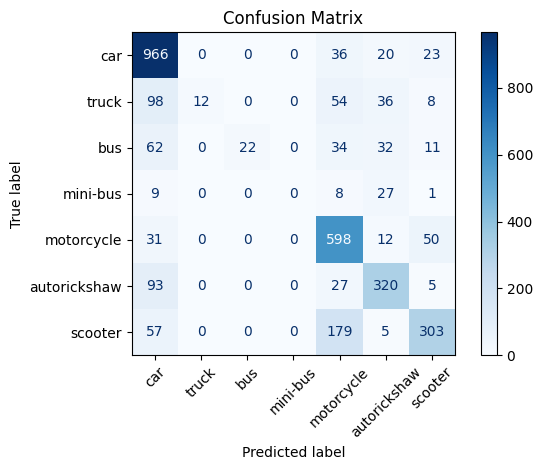

Overall Accuracy: 0.7076


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from xml.etree import ElementTree as ET
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)
from skimage.feature import hog
from imutils.object_detection import non_max_suppression
import pandas as pd
import joblib

# --- Configuration ---
image_dir = Path(r"D:\NLPInsuranceProject\AutonomousDrivingGanMV\idd detection\IDD_FGVD\train\images")  # Replace with your actual path
xml_dir = Path(r"D:\NLPInsuranceProject\AutonomousDrivingGanMV\idd detection\IDD_FGVD\train\annos")
win_size = (64, 128)
scale_factor = 1.2
threshold = 0.5  # Confidence threshold for detection

# Class names mapping (adjust according to your dataset)
CLASS_MAPPING = {
    'car': 0,
    'truck': 1,
    'bus': 2,
    'mini-bus': 3,
    'motorcycle': 4,
    'autorickshaw': 5,
    'scooter': 6
}

hog_params = {
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'orientations': 9,
    'block_norm': 'L2-Hys'
}

# --- Helper Functions ---
def safe_parse_coordinate(text):
    try:
        return int(round(float(text)))
    except (ValueError, TypeError, AttributeError):
        return None

def extract_features(img, bbox=None):
    """Extract HOG features from an image or patch with safety checks"""
    try:
        if bbox:
            # Get image dimensions
            h, w = img.shape[:2]
            ymin = max(0, bbox['ymin'])
            ymax = min(h, bbox['ymax'])
            xmin = max(0, bbox['xmin'])
            xmax = min(w, bbox['xmax'])
            if ymax <= ymin or xmax <= xmin:
                return None
            patch = img[ymin:ymax, xmin:xmax]
        else:
            patch = img
        
        if patch.size == 0:
            return None
            
        if patch.shape[0] < 10 or patch.shape[1] < 10:  # Minimum viable size
            return None
        
        patch = cv2.resize(patch, win_size)
        gray = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
        
        return hog(gray, **hog_params)
        
    except Exception as e:
        print(f"Feature extraction failed: {str(e)}")
        return None

def parse_voc(xml_path):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        size = root.find('size')
        img_width = int(size.find('width').text)
        img_height = int(size.find('height').text)
        
        objects = []
        for obj in root.findall("object"):
            class_name = obj.find("name").text.lower().strip()
            if class_name not in CLASS_MAPPING:
                continue
            bbox = obj.find("bndbox")
            coords = {
                'xmin': safe_parse_coordinate(bbox.find("xmin").text),
                'ymin': safe_parse_coordinate(bbox.find("ymin").text),
                'xmax': safe_parse_coordinate(bbox.find("xmax").text),
                'ymax': safe_parse_coordinate(bbox.find("ymax").text),
                'class': class_name,
                'class_id': CLASS_MAPPING[class_name]
            }
            if all(v is not None for v in [coords['xmin'], coords['ymin'], coords['xmax'], coords['ymax']]):
                if (0 <= coords['xmin'] < coords['xmax'] <= img_width and
                    0 <= coords['ymin'] < coords['ymax'] <= img_height):
                    objects.append(coords)
                    
        return objects
    except Exception as e:
        print(f"XML parsing error in {xml_path.name}: {str(e)}")
        return []

# --- Sliding Window and Pyramid ---
def sliding_window(image, step_size=16, window_size=win_size):
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def pyramid(image, scale=1.5, min_size=(64, 128)):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        h = int(image.shape[0] / scale)
        image = cv2.resize(image, (w, h))
        if image.shape[0] < min_size[1] or image.shape[1] < min_size[0]:
            break
        yield image

# --- Detection and Classification ---
def detect_and_classify(image, model, threshold=0.5):
    detections = []
    scale = 1.0
    
    for resized in pyramid(image, scale=scale_factor):
        scale_x = image.shape[1] / float(resized.shape[1])
        scale_y = image.shape[0] / float(resized.shape[0])
        
        for (x, y, window) in sliding_window(resized):
            if window.shape[0] != win_size[1] or window.shape[1] != win_size[0]:
                continue
                
            features = extract_features(window)
            if features is None:
                continue
                
            features = features.reshape(1, -1)
            pred_proba = model.predict_proba(features)[0]
            pred_class = model.predict(features)[0]
            confidence = np.max(pred_proba)
            
            if confidence > threshold:
                x1 = int(x * scale_x)
                y1 = int(y * scale_y)
                x2 = int((x + win_size[0]) * scale_x)
                y2 = int((y + win_size[1]) * scale_y)
                
                detections.append({
                    'box': (x1, y1, x2, y2),
                    'class': pred_class,
                    'class_name': list(CLASS_MAPPING.keys())[list(CLASS_MAPPING.values()).index(pred_class)],
                    'confidence': confidence
                })
    
    # Apply non-maxima suppression
    boxes = np.array([d['box'] for d in detections])
    confidences = np.array([d['confidence'] for d in detections])
    
    if len(boxes) > 0:
        pick = non_max_suppression(boxes, probs=confidences, overlapThresh=0.3)
        final_detections = [detections[i] for i in pick]
        return final_detections
    return []

# --- Evaluation Metrics ---
def evaluate_classification(y_true, y_pred):
    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=list(CLASS_MAPPING.keys())))
    
    print("\n=== Confusion Matrix ===")
    cm = confusion_matrix(y_true, y_pred, labels=list(CLASS_MAPPING.values()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(CLASS_MAPPING.keys()))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f}")
    return accuracy

# --- Saving Results to CSV ---
def save_results_to_csv(results, filename='detection_results.csv'):
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)

# --- Random Forest Model Training ---
def train_random_forest(model, images, xml_paths):
    features = []
    labels = []
    results = []  # Store results for CSV

    for xml_path in xml_paths:
        img_path = image_dir / (xml_path.stem + ".jpg")
        
        if not img_path.exists():
            print(f"Skipping missing image: {img_path.name}")
            continue
        
        image = cv2.imread(str(img_path))
        
        if image is None or image.size == 0:
            print(f"Skipping empty image: {img_path.name}")
            continue
        
        gt_objects = parse_voc(xml_path)
        for obj in gt_objects:
            bbox = obj
            feature = extract_features(image, bbox)
            if feature is not None:
                features.append(feature)
                labels.append(bbox['class_id'])
                results.append({
                    'image': img_path.name,
                    'ground_truth': bbox['class'],
                    'bbox': bbox,
                    'predicted_class': None,
                    'confidence': None
                })

    if len(features) == 0:
        print("No valid features extracted.")
        return model, results

    features = np.array(features)
    labels = np.array(labels)

    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate
    evaluate_classification(y_test, y_pred)

    # Save results to CSV
    save_results_to_csv(results)

    # Save model
    joblib.dump(model, 'random_forest_model.joblib')
    
    return model, results

# --- Main Code ---
if __name__ == '__main__':
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # List all XML files in the directory
    xml_files = list(xml_dir.glob("*.xml"))
    
    rf_model, results = train_random_forest(rf_model, image_dir, xml_files)


In [1]:
import os
import cv2
import numpy as np
import joblib
from skimage.feature import hog
from imutils.object_detection import non_max_suppression

# ====== CONFIGURATION ====== 
# Path to your single test image
input_image_path = r"D:\NLPInsuranceProject\AutonomousDrivingGanMV\task1test\14.png"
# Path to save the output (set to None to disable saving)
output_path = None
# Path to your trained model
model_path = r"D:\NLPInsuranceProject\AutonomousDrivingGanMV\idd detection\random_forest_model.joblib"

# Detection parameters
win_size = (64, 128)  # Sliding window size
hog_params = {
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'orientations': 9,
    'block_norm': 'L2-Hys'
}
threshold = 0.5  # Confidence threshold
# ===========================

# Load the trained Random Forest model
rf_model = joblib.load(model_path)

def sliding_window(image, step_size=16, window_size=win_size):
    """Generate sliding window patches"""
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def extract_features(img):
    """Extract HOG features from a patch"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features = hog(gray, **hog_params)
    return features.reshape(1, -1)

def detect_and_classify(image):
    """Main detection and classification function"""
    detections = []
    
    # Slide window across the image
    for (x, y, window) in sliding_window(image):
        features = extract_features(window)
        if features is None:
            continue
            
        # Make prediction
        prediction = rf_model.predict(features)
        confidence = rf_model.predict_proba(features).max()

        if confidence > threshold:
            detections.append((x, y, x + win_size[0], y + win_size[1], prediction[0], confidence))
    
    # Apply non-maxima suppression
    if len(detections) > 0:
        boxes = np.array([d[:4] for d in detections])
        confidences = np.array([d[5] for d in detections])
        
        # Get indices of surviving boxes
        pick = non_max_suppression(boxes, probs=confidences, overlapThresh=0.3)
        if len(pick) > 0:
            # Convert box coordinates to indices
            indices = []
            for p in pick:
                matches = np.where((boxes == p).all(axis=1))[0]
                if len(matches) > 0:
                    indices.append(matches[0])
            detections = [detections[i] for i in indices]

    return detections

# Load and verify the input image
image = cv2.imread(input_image_path)
if image is None:
    print(f"Error: Could not read image from {input_image_path}")
    exit()

# Perform detection and classification
detections = detect_and_classify(image)

# Draw detections on the image
for (x1, y1, x2, y2, label, confidence) in detections:
    # Draw bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Put label and confidence
    label_text = f"Class {label} ({confidence:.2f})"
    cv2.putText(image, label_text, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display results
cv2.imshow("Object Detection Results", image)
cv2.waitKey(0)  # Wait until any key is pressed

# Save output if path is specified
if output_path:
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, image)
    print(f"Result saved to {output_path}")

cv2.destroyAllWindows()
print("Processing completed successfully.")

Processing completed successfully.


### HOG + SVM 

Processing 3535 files...

--- Classification Report ---
              precision    recall  f1-score   support

autorickshaw       0.73      0.84      0.78       455
         bus       0.64      0.62      0.63       151
         car       0.87      0.84      0.85      1056
    mini-bus       0.71      0.60      0.65        40
  motorcycle       0.77      0.75      0.76       696
     scooter       0.70      0.70      0.70       549
       truck       0.63      0.58      0.61       183

    accuracy                           0.77      3130
   macro avg       0.72      0.71      0.71      3130
weighted avg       0.77      0.77      0.77      3130


Detections for 0.jpg:
Found 1205 objects


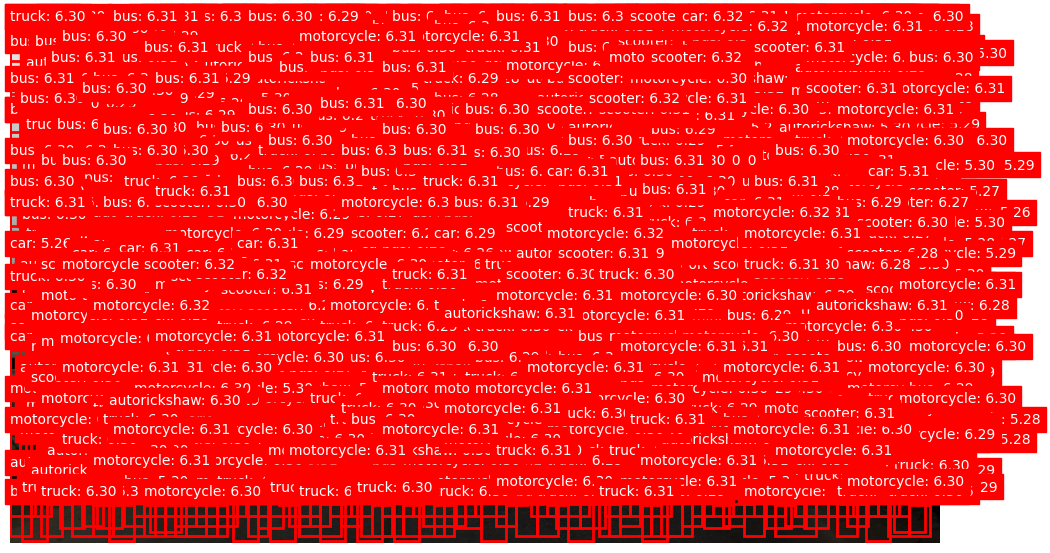

Ground truth:


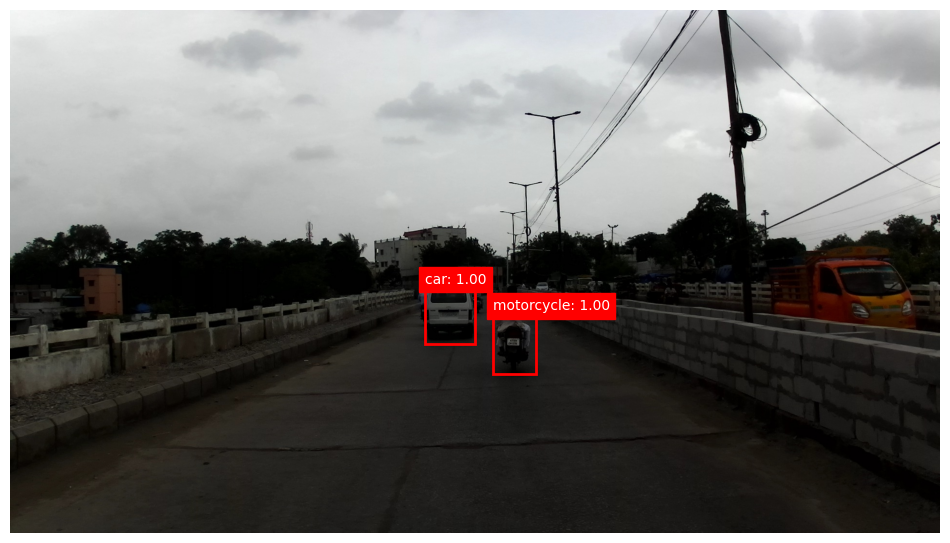

KeyboardInterrupt: 

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from pathlib import Path
from xml.etree import ElementTree as ET
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- Config ---
image_dir = Path(r"D:\NLPInsuranceProject\AutonomousDrivingGanMV\idd detection\IDD_FGVD\train\images")
xml_dir = Path(r"D:\NLPInsuranceProject\AutonomousDrivingGanMV\idd detection\IDD_FGVD\train\annos")
win_size = (64, 128)  # Window size for HOG features
hog_params = {
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'orientations': 9,
    'block_norm': 'L2-Hys'
}
# Sliding window parameters
step_size = 32  # Step size for sliding window
scales = [0.5, 0.75, 1.0, 1.25, 1.5]  # Different scales to search
iou_threshold = 0.3  # Threshold for non-max suppression
detection_threshold = 0.7  # Confidence threshold for detection

# --- Helper Functions ---
def safe_parse(text):
    try:
        return int(round(float(text)))
    except:
        return None

def parse_voc(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    bboxes, labels = [], []
    
    for obj in root.findall("object"):
        label = obj.find("name").text
        bbox = obj.find("bndbox")
        xmin = safe_parse(bbox.find("xmin").text)
        ymin = safe_parse(bbox.find("ymin").text)
        xmax = safe_parse(bbox.find("xmax").text)
        ymax = safe_parse(bbox.find("ymax").text)
        
        if None in (xmin, ymin, xmax, ymax) or xmax <= xmin or ymax <= ymin:
            continue
        
        bboxes.append((xmin, ymin, xmax, ymax))
        labels.append(label)
    return bboxes, labels

def extract_hog_features(img_patch):
    gray = cv2.cvtColor(img_patch, cv2.COLOR_RGB2GRAY)
    features = hog(gray, visualize=False, **hog_params)
    return features

def non_max_suppression(boxes, scores, threshold):
    """
    Apply non-max suppression to eliminate redundant overlapping boxes
    
    Args:
        boxes: list of bounding boxes in format (x1, y1, x2, y2)
        scores: list of confidence scores for each box
        threshold: IoU threshold for suppression
    
    Returns:
        list of indices of boxes to keep
    """
    if len(boxes) == 0:
        return []
    
    # Convert to numpy arrays
    boxes = np.array(boxes)
    scores = np.array(scores)
    
    # Initialize the list of picked indices
    pick = []
    
    # Get coordinates of bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    
    # Compute area of boxes and sort by score
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)[::-1]
    
    while len(idxs) > 0:
        # Grab last index (highest score) and add to picked list
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        
        # Find intersection coordinates
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        
        # Compute width and height of intersection
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        # Compute intersection over union
        overlap = (w * h) / (area[idxs[:last]] + area[i] - (w * h))
        
        # Delete indices where overlap exceeds threshold
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > threshold)[0])))
    
    return pick

# --- Feature Collection ---
def collect_dataset():
    X_class, y_class = [], []
    label_encoder = LabelEncoder()

    xml_files = list(xml_dir.glob("*.xml"))
    print(f"Processing {len(xml_files)} files...")

    # First pass to collect all labels
    all_labels = []
    for xml_path in xml_files:
        bboxes, labels = parse_voc(xml_path)
        all_labels.extend(labels)
    label_encoder.fit(all_labels)

    # Second pass to collect features
    for xml_path in xml_files:
        img_path = image_dir / (xml_path.stem + ".jpg")
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        bboxes, labels = parse_voc(xml_path)

        for (bbox, label) in zip(bboxes, labels):
            xmin, ymin, xmax, ymax = bbox
            patch = img[ymin:ymax, xmin:xmax]
            if patch.shape[0] < 20 or patch.shape[1] < 20:
                continue
            patch = cv2.resize(patch, win_size)
            features = extract_hog_features(patch)

            X_class.append(features)
            y_class.append(label_encoder.transform([label])[0])

    return np.array(X_class), np.array(y_class), label_encoder

# --- Sliding Window Detection ---
def sliding_window_detection(image, clf, scaler, label_encoder):
    """
    Perform object detection using sliding window approach
    
    Args:
        image: input image (RGB format)
        clf: trained SVM classifier
        scaler: feature scaler
        label_encoder: label encoder for class names
    
    Returns:
        list of detected bounding boxes, labels, and scores
    """
    orig_h, orig_w = image.shape[:2]
    detections = []
    
    for scale in scales:
        # Resize image according to current scale
        scaled_w = int(orig_w * scale)
        scaled_h = int(orig_h * scale)
        scaled_img = cv2.resize(image, (scaled_w, scaled_h))
        
        # Slide window across the image
        for y in range(0, scaled_h - win_size[1], step_size):
            for x in range(0, scaled_w - win_size[0], step_size):
                # Extract window
                window = scaled_img[y:y+win_size[1], x:x+win_size[0]]
                
                # Extract features and predict
                features = extract_hog_features(window)
                features = scaler.transform([features])
                confidence = clf.decision_function(features)[0]
                pred_class = clf.predict(features)[0]
                max_confidence = np.max(confidence)
                
                if max_confidence > detection_threshold:
                    # Calculate bounding box coordinates in original image
                    x1 = int(x / scale)
                    y1 = int(y / scale)
                    x2 = int((x + win_size[0]) / scale)
                    y2 = int((y + win_size[1]) / scale)
                    
                    # Get class label
                    label = label_encoder.inverse_transform([pred_class])[0]
                    
                    detections.append((x1, y1, x2, y2, label, max_confidence))
    
    # Apply non-max suppression
    if len(detections) > 0:
        boxes = [d[:4] for d in detections]
        labels = [d[4] for d in detections]
        scores = [d[5] for d in detections]
        
        # Apply NMS
        keep_indices = non_max_suppression(boxes, scores, iou_threshold)
        
        # Return filtered detections
        return [boxes[i] for i in keep_indices], [labels[i] for i in keep_indices], [scores[i] for i in keep_indices]
    else:
        return [], [], []

# --- Model Training and Evaluation ---
def train_and_evaluate():
    X_class, y_class, label_encoder = collect_dataset()
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_class, y_class, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train SVM classifier
    clf = SVC(kernel='linear', probability=True)
    clf.fit(X_train, y_train)
    
    # Evaluate classifier
    y_pred = clf.predict(X_test)
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    return clf, scaler, label_encoder

# --- Visualization ---
def visualize_detections(image, boxes, labels, scores):
    """Visualize detections on image"""
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()
    
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        
        rect = plt.Rectangle((x1, y1), width, height, 
                            fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        
        plt.text(x1, y1, f"{label}: {score:.2f}", 
                color='white', backgroundcolor='red', fontsize=10)
    
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    # Train the classifier
    clf, scaler, label_encoder = train_and_evaluate()
    
    # Test on sample images
    test_files = list(xml_dir.glob("*.xml"))[:5]  # Test on first 5 images
    for xml_path in test_files:
        img_path = image_dir / (xml_path.stem + ".jpg")
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get ground truth boxes
        gt_boxes, gt_labels = parse_voc(xml_path)
        
        # Run detection
        boxes, labels, scores = sliding_window_detection(img, clf, scaler, label_encoder)
        
        # Visualize results
        print(f"\nDetections for {img_path.name}:")
        print(f"Found {len(boxes)} objects")
        visualize_detections(img, boxes, labels, scores)
        
        # Also show ground truth for comparison
        print("Ground truth:")
        visualize_detections(img, gt_boxes, gt_labels, [1.0]*len(gt_boxes))